In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# 1. Load data
csv_files = glob.glob("../data/raw_data/*.csv")
dfs = {}
for file in csv_files:
    symbol = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file, parse_dates=["trade_date"] )
    df.set_index("trade_date", inplace=True)

    df = df[~df.index.duplicated(keep='first')]
    num_cols = ["open", "high", "low", "close", "vol", "pct_change", "vwap"]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    df['return'] = df['pct_change'] / 100.0

    dfs[symbol] = df


In [3]:
len(list(dfs.keys()))


496

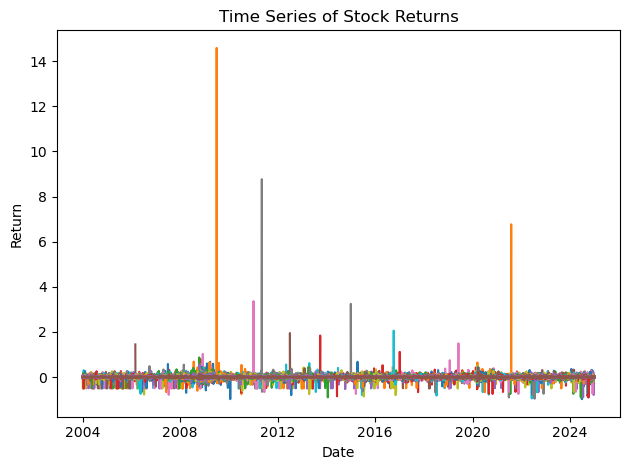

In [4]:
# 3. Comparison of all stocks' returns on time series
returns_df = pd.DataFrame({sym: df['return'] for sym, df in dfs.items()})

plt.figure()
for sym in returns_df.columns:
    plt.plot(returns_df.index, returns_df[sym], label=sym)
plt.title("Time Series of Stock Returns")
plt.xlabel("Date")
plt.ylabel("Return")
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

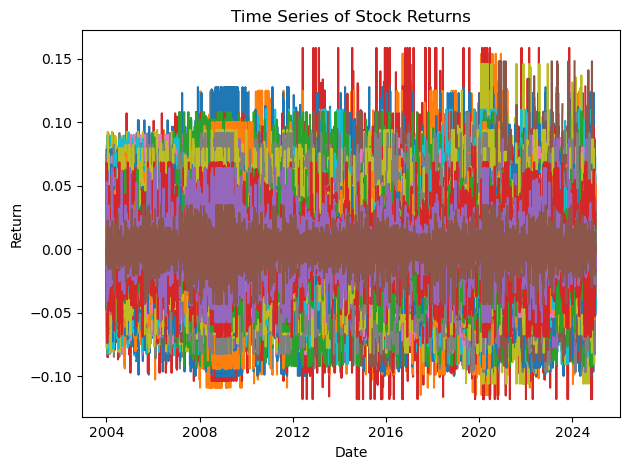

In [5]:
# 4. Outlier handling on combined returns_df
lower = returns_df.quantile(0.01)
upper = returns_df.quantile(0.99)
returns_df = returns_df.clip(lower=lower, upper=upper, axis=1)
plt.figure()
for sym in returns_df.columns:
    plt.plot(returns_df.index, returns_df[sym], label=sym)
plt.title("Time Series of Stock Returns")
plt.xlabel("Date")
plt.ylabel("Return")
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [6]:
# 5. Unit root testing (ADF and KPSS)
unit_root = []
for sym, df in dfs.items():
    series = df['return'].dropna()
    # ADF
    adf_res = adfuller(series)
    # KPSS
    kpss_res = kpss(series, nlags='auto')
    unit_root.append({
        'symbol': sym,
        'adf_stat': adf_res[0],
        'adf_pvalue': adf_res[1],
        'kpss_stat': kpss_res[0],
        'kpss_pvalue': kpss_res[1]
    })
unit_root_df = pd.DataFrame(unit_root).set_index('symbol')
unit_root_df['stationary'] = np.where((unit_root_df['adf_pvalue'] < 0.05) & (unit_root_df['kpss_pvalue'] > 0.05), True, False)

print("=== Unit Root Test Results ===")
print(unit_root_df)



/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_79647/1649762648.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_79647/1649762648.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_79647/1649762648.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_79647/1649762648.py:8: InterpolationWarning: The test statistic is outside

=== Unit Root Test Results ===
         adf_stat    adf_pvalue  kpss_stat  kpss_pvalue  stationary
symbol                                                             
CSCO   -17.848064  3.087298e-30   0.059682     0.100000        True
UAL    -11.888464  5.945969e-22   0.034070     0.100000        True
TROW   -17.724036  3.458134e-30   0.046001     0.100000        True
ISRG   -72.453281  0.000000e+00   0.432569     0.063117        True
NVR    -28.955290  0.000000e+00   0.055120     0.100000        True
...           ...           ...        ...          ...         ...
IEX    -38.646614  0.000000e+00   0.070675     0.100000        True
BWA    -72.999543  0.000000e+00   0.041350     0.100000        True
LRCX   -32.277671  0.000000e+00   0.085574     0.100000        True
BLK    -17.580846  4.008050e-30   0.084188     0.100000        True
PPL    -34.853274  0.000000e+00   0.025155     0.100000        True

[496 rows x 5 columns]


/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_79647/1649762648.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags='auto')


In [7]:
unit_root_df['stationary'] = np.where((unit_root_df['adf_pvalue'] < 0.05) & (unit_root_df['kpss_pvalue'] > 0.05), 1, 0)

print("=== Unit Root Test Results ===")
print(unit_root_df)

=== Unit Root Test Results ===
         adf_stat    adf_pvalue  kpss_stat  kpss_pvalue  stationary
symbol                                                             
CSCO   -17.848064  3.087298e-30   0.059682     0.100000           1
UAL    -11.888464  5.945969e-22   0.034070     0.100000           1
TROW   -17.724036  3.458134e-30   0.046001     0.100000           1
ISRG   -72.453281  0.000000e+00   0.432569     0.063117           1
NVR    -28.955290  0.000000e+00   0.055120     0.100000           1
...           ...           ...        ...          ...         ...
IEX    -38.646614  0.000000e+00   0.070675     0.100000           1
BWA    -72.999543  0.000000e+00   0.041350     0.100000           1
LRCX   -32.277671  0.000000e+00   0.085574     0.100000           1
BLK    -17.580846  4.008050e-30   0.084188     0.100000           1
PPL    -34.853274  0.000000e+00   0.025155     0.100000           1

[496 rows x 5 columns]


In [8]:
unit_root_df.describe()

,adf_stat,adf_pvalue,kpss_stat,kpss_pvalue,stationary
count,496.000000,4.960000e+02,496.000000,496.000000,496.000000
mean,-26.320974,2.292584e-10,0.115595,0.097138,0.967742
std,17.470575,5.105823e-09,0.124072,0.013534,0.176863
min,-77.920836,0.000000e+00,0.013336,0.010000,0.000000
25%,-28.653491,0.000000e+00,0.043893,0.100000,1.000000
50%,-18.882699,0.000000e+00,0.072761,0.100000,1.000000
75%,-14.572180,4.614252e-27,0.137682,0.100000,1.000000
max,-6.073311,1.137121e-07,1.011941,0.100000,1.000000


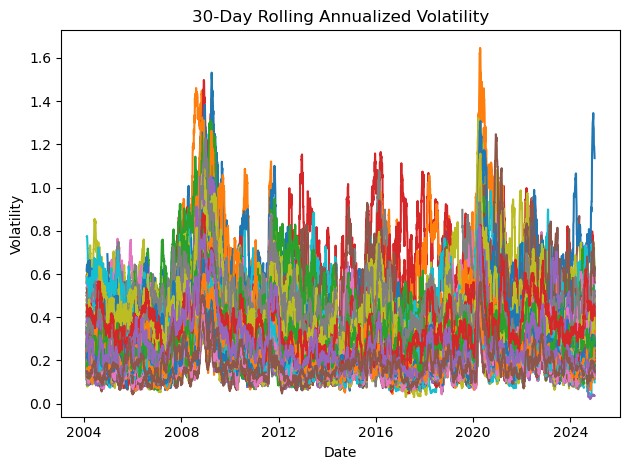

In [9]:
# 5. Volatility analysis: rolling standard deviation
window = 30  # days
vol_df = returns_df.rolling(window).std() * np.sqrt(252)  # annualized volatility

plt.figure()
for sym in vol_df.columns:
    plt.plot(vol_df.index, vol_df[sym], label=sym)
plt.title(f"{window}-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
#plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [10]:
# 6. Seasonality: seasonal decomposition of closing price for each stock
seasonal_results = {}
for sym, df in dfs.items():
    # use closing price series
    series = df['close'].asfreq('B')  # business-day frequency
    series = series.interpolate()
    if len(series) < 504:
        print(f"Not enough data for {sym} for seasonal decomposition.")
        continue
    decomposition = seasonal_decompose(series, model='additive', period=252)
    seasonal_results[sym] = decomposition
    # Plot
    #fig = decomposition.plot()
    #fig.suptitle(f"Seasonal Decomposition for {sym}")
    #plt.tight_layout()
    #plt.show()



Not enough data for EG for seasonal decomposition.
Not enough data for CPAY for seasonal decomposition.
Not enough data for DAY for seasonal decomposition.


In [11]:
# 7. Seasonal strength metric
# Seasonal strength = var(seasonal) / (var(seasonal) + var(resid))
strength = {}
for sym, dec in seasonal_results.items():
    var_seas = np.nanvar(dec.seasonal)
    var_resid = np.nanvar(dec.resid)
    strength[sym] = var_seas / (var_seas + var_resid)
strength_df = pd.Series(strength, name='seasonal_strength')
print("=== Seasonal Strength by Symbol ===")
print(strength_df)


=== Seasonal Strength by Symbol ===
CSCO    0.041265
UAL     0.045949
TROW    0.026671
ISRG    0.060913
NVR     0.022066
          ...   
IEX     0.029072
BWA     0.041708
LRCX    0.041079
BLK     0.051545
PPL     0.072590
Name: seasonal_strength, Length: 493, dtype: float64


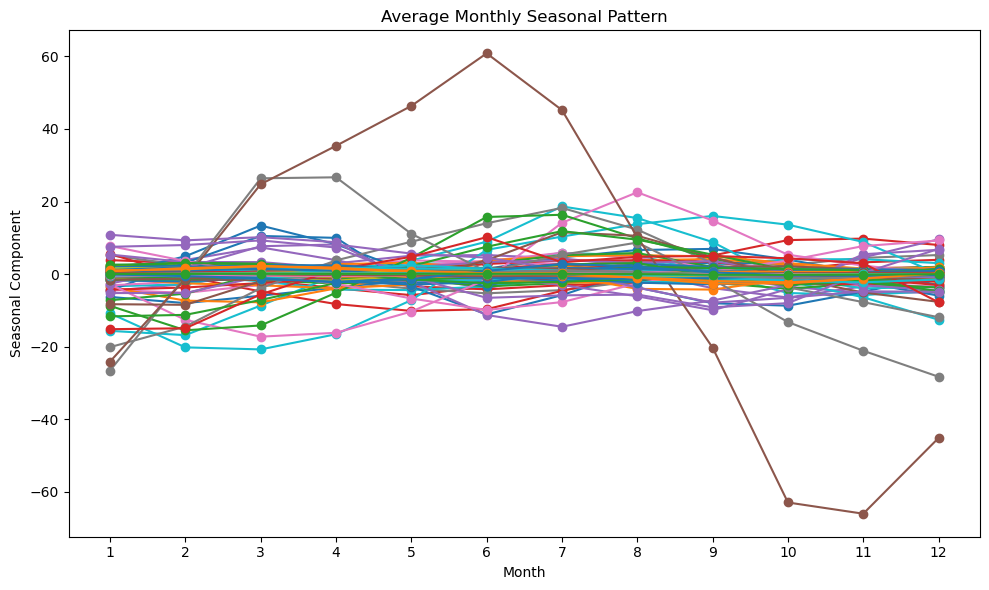

In [12]:
# 8. Average monthly seasonal pattern
# Align all seasonal series and compute mean by month-of-year
all_seasonal = pd.DataFrame({sym: dec.seasonal for sym, dec in seasonal_results.items()})
all_seasonal.index = pd.DatetimeIndex(all_seasonal.index)
monthly_pattern = all_seasonal.groupby(all_seasonal.index.month).mean()

plt.figure(figsize=(10,6))
for sym in monthly_pattern.columns:
    plt.plot(monthly_pattern.index, monthly_pattern[sym], marker='o', label=sym)
plt.title('Average Monthly Seasonal Pattern')
plt.xlabel('Month')
plt.ylabel('Seasonal Component')
plt.xticks(range(1,13))
#plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [ ]:
# 9 box test and arch effect
from statsmodels.stats.diagnostic import acorr_ljungbox

box_test = []
for sym, df in dfs.items():
    series = df['return'].dropna()
    # ADF
    result_ = acorr_ljungbox(series, lags=20, return_df=False).iloc[-1]
    
    result_arch = acorr_ljungbox(series**2, lags=20, return_df=False).iloc[-1]
    
    box_test.append({
        'symbol': sym,
        'box_stat': result_['lb_stat'],
        'box_pvalue': result_['lb_pvalue'],
        'ARCH_stats': result_arch['lb_stat'],
        'ARCH_pvalue': result_arch['lb_pvalue']
    })

box_test_df = pd.DataFrame(box_test).set_index('symbol')

box_test_df['Exist_Arch_Effect'] = np.where(box_test_df['ARCH_pvalue'] < 0.05, True, False)
box_test_df['Exist_Autocorr'] = np.where(box_test_df['box_pvalue'] < 0.05, True, False)
print("=== Box Test Results ===")
print(box_test_df)


Index(['box_stat', 'box_pvalue', 'ARCH_stats', 'ARCH_pvalue',
       'Exist_Arch_Effect', 'Exist_Autocorr'],
      dtype='object')
=== Box Test Results ===
          box_stat    box_pvalue   ARCH_stats    ARCH_pvalue  \
symbol                                                         
CSCO     67.478067  4.674679e-07   761.786331  1.811434e-148   
UAL     103.577842  2.868218e-13  1307.371199  7.807644e-265   
TROW     97.538630  3.464052e-12   173.037632   2.221565e-26   
ISRG     20.551585  4.239347e-01     0.780361   1.000000e+00   
NVR      52.514951  9.574642e-05  3077.823978   0.000000e+00   
...            ...           ...          ...            ...   
IEX      42.684958  2.249529e-03    57.144022   1.951868e-05   
BWA      34.432914  2.334107e-02     9.009057   9.828021e-01   
LRCX     64.025593  1.667001e-06     2.222613   9.999997e-01   
BLK     108.544980  3.615321e-14  5042.742928   0.000000e+00   
PPL      37.856417  9.220103e-03    15.780309   7.301565e-01   

        Exi